# DSN 発表用スクリプト
3/15

In [1]:
import os
import sys

In [6]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import pymc3 as pm

In [7]:
import numpy as np
np.random.seed(0)

In [5]:
path_fig = "../figures/"

## バンディット問題を解くアルゴリズム

### 環境の設定

In [41]:
n_arms = 4

In [42]:
class Env(object):
    thetas = [0.1, 0.1, 0.2, 0.3]
    
    def react(arm):
        return 1 if np.random.random() < Env.thetas[arm] else 0
    
    def opt():
        return np.argmax(Env.thetas)

### $\epsilon$ greedy

In [43]:
class EpsilonGreedyAgent(object):
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        
    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm]-1) * self.values[arm] + reward
        ) / self.counts[arm]

In [44]:
def sim(Agent, N=1000, T=1000, **kwargs):
    selected_arm = [[0 for _ in range(T)] for _ in range(N)]
    earned_rewards = [[0 for _ in range(T)] for _ in range(N)]
    
    for n in tqdm(range(N)):
        agent = Agent(**kwargs)
        for t in range(T):
            arm = agent.get_arm()
            reward = Env.react(arm)
            agent.sample(arm, reward)
            selected_arm[n][t] = arm
            earned_rewards[n][t] = reward
    return np.array(selected_arm), np.array(earned_rewards)

In [45]:
arms_eg, rewards_eg = sim(EpsilonGreedyAgent)
acc = np.mean(arms_eg == Env.opt(), axis=0)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 207.08it/s]


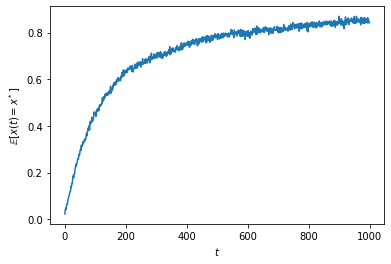

In [46]:
plt.tight_layout()
plt.plot(acc)
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.savefig(path_fig + "result_epsilon_greedy.png", bbox_inches="tight")
plt.show()

### Annealing $\epsilon$ greedy

In [47]:
class AnnealingEpsilonGreedyAgent(object):
    def __init__(self, epsilon=1.0):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        
    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        self.epsilon *= 0.99
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm]-1) * self.values[arm] + reward
        ) / self.counts[arm]

In [48]:
arms_aeg, rewards_aeg = sim(AnnealingEpsilonGreedyAgent)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 206.29it/s]


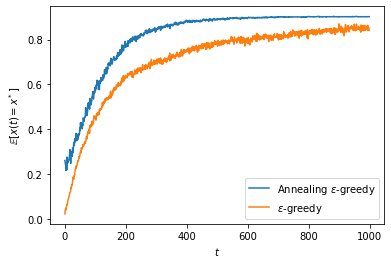

In [49]:
plt.tight_layout()
plt.plot(np.mean(arms_aeg == Env.opt(), axis=0), label=r'Annealing $\epsilon$-greedy')
plt.plot(np.mean(arms_eg == Env.opt(), axis=0), label=r'$\epsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.savefig(path_fig + "result_annealing_epsilon_greedy.png", bbox_inches="tight")
plt.show()

### Thompson sampling

In [50]:
class BernoulliTSAgent(object):
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.wins = [0 for _ in range(n_arms)]
        
    def get_arm(self):
        beta = lambda N, a: np.random.beta(a+1, N-a+1)
        result = [beta(self.counts[i], self.wins[i]) for i in range(n_arms)]
        arm = result.index(max(result))
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.wins[arm] = self.wins[arm] + reward

In [51]:
arms_ts, rewards_ts = sim(BernoulliTSAgent)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.49it/s]


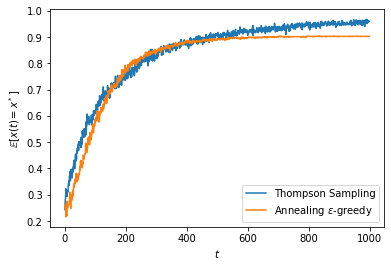

In [52]:
plt.tight_layout()
plt.plot(np.mean(arms_ts == Env.opt(), axis=0), label=r'Thompson Sampling')
plt.plot(np.mean(arms_aeg == Env.opt(), axis=0), label=r'Annealing $\epsilon$-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.savefig(path_fig + "result_thompson_sampling.png", bbox_inches="tight")
plt.show()

### UCB Algorithms

In [53]:
class UCBAgent(object):
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0 for _ in range(n_arms)]
        
    def calc_ucb(self, arm):
        ucb = self.values[arm]
        ucb += np.sqrt(np.log(sum(self.counts)) / (2 * self.counts[arm]))
        return ucb
        
    def get_arm(self):
        # 一回も選択されていない腕があればそれを選ぶ
        if 0 in self.counts:
            arm = self.counts.index(0)
        else:
            ucb = [self.calc_ucb(arm) for arm in range(n_arms)]
            arm = ucb.index(max(ucb))
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

In [54]:
arms_ucb, rewards_ucb = sim(UCBAgent)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.01it/s]


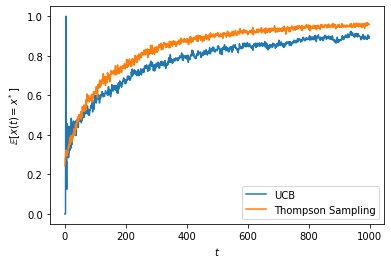

In [55]:
plt.plot(np.mean(arms_ucb == Env.opt(), axis=0), label=r'UCB')
plt.plot(np.mean(arms_ts == Env.opt(), axis=0), label=r'Thompson Sampling')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.savefig(path_fig + "result_ucb.png", bbox_inches="tight")
plt.show()

## 特徴量を考慮する

### 環境の設定

In [56]:
arms = [[0,0], [0,1], [1,0], [1,1]]
# 4番目の腕[1,1]が最適
class Env(object):
    def p(arm):
        x = arm[0]*0.2 + arm[1]*0.8 - 4
        return 1 / (1+np.exp(-x))
    
    def react(arm):
        return 1 if np.random.random() < Env.p(arm) else 0
    
    def opt():
        return np.argmax([Env.p(arm) for arm in arms])

### Lin UCB

In [64]:
# 逆行列の計算をウッドベリーの公式を用いて短縮
class LinUCBAgent(object):
    def __init__(self, alpha=1, sigma=1):
        self.phis = np.array([[arm[0], arm[1], 1] for arm in arms]).T
        self.alpha = alpha
        self.sigma = sigma
        self.inv_A = np.identity(self.phis.shape[0])
        self.b = np.zeros((self.phis.shape[0],1))
        self.counts = [0 for _ in range(n_arms)]
        
    def get_arm(self):
        post_mean = self.inv_A.dot(self.b)
        post_var = self.inv_A
        pred_mean = self.phis.T.dot(post_mean)
        pred_var = self.phis.T.dot(post_var).dot(self.phis)
        ucb = pred_mean.T + self.alpha * np.sqrt(np.diag(pred_var))
        return np.argmax(ucb)
    
    def sample(self, arm_index, reward):
        phi = self.phis[:, [arm_index]]
        iAppTiA = self.inv_A.dot(phi).dot(phi.T).dot(self.inv_A)
        s2_pTiAp = self.sigma ** 2 + phi.T.dot(self.inv_A).dot(phi)
        self.inv_A = self.inv_A - iAppTiA / s2_pTiAp
        self.b += phi * reward * (self.sigma ** 2)
        self.counts[arm_index] += 1

In [65]:
n_iter = 500
n_step = 5000
selected_arms_linucb = np.zeros((n_iter, n_step), dtype=int)
earned_rewards_linucb = np.zeros((n_iter, n_step), dtype=int)
for it in tqdm(range(n_iter)):
    agent = LinUCBAgent()
    for step in range(n_step):
        arm_index = agent.get_arm()
        reward = Env.react(arms[arm_index])
        agent.sample(arm_index, reward)
        selected_arms_linucb[it, step] = arm_index
        earned_rewards_linucb[it, step] = reward

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.46it/s]


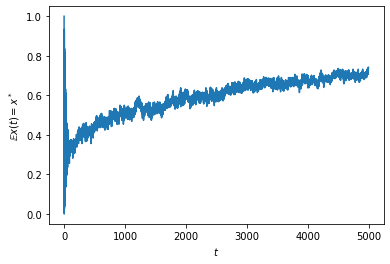

In [66]:
plt.plot(np.mean(selected_arms_linucb==Env.opt(), axis=0))
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}{x(t) = x^*}$')
plt.savefig(path_fig + "result_linucb.png", bbox_inches="tight")
plt.show()

### Compare with normal UCB

In [67]:
class UCBAgent(object):
    def __init__(self):
        self.counts = [0 for _ in range(n_arms)]
        self.values = [0 for _ in range(n_arms)]
        
    def calc_ucb(self, arm):
        ucb = self.values[arm]
        ucb += np.sqrt(np.log(sum(self.counts)) / (2 * self.counts[arm]))
        return ucb
        
    def get_arm(self):
        # 一回も選択されていない腕があればそれを選ぶ
        if 0 in self.counts:
            arm = self.counts.index(0)
        else:
            ucb = [self.calc_ucb(arm) for arm in range(n_arms)]
            arm = ucb.index(max(ucb))
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm] - 1) * self.values[arm] + reward
        ) / self.counts[arm]

In [68]:
agent_classes = [LinUCBAgent, UCBAgent]
n_arms = len(arms)
n_iter = 500
n_step = 5000
selected_arms = np.zeros((n_iter, len(agent_classes), n_step), dtype=int)
earned_rewards = np.zeros((n_iter, len(agent_classes), n_step), dtype=int)

In [69]:
for it in tqdm(range(n_iter)):
    for i, agent_class in enumerate(agent_classes):
        agent = agent_class()
        for step in range(n_step):
            arm_index = agent.get_arm()
            arm = arms[arm_index]
            reward = Env.react(arm)
            agent.sample(arm_index, reward)
            selected_arms[it, i, step] = arm_index
            earned_rewards[it, i, step] = reward

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:08<00:00,  3.91it/s]


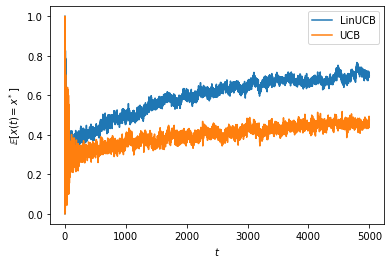

In [70]:
acc = np.mean(selected_arms==Env.opt(), axis=0)
plt.plot(acc[0], label='LinUCB')
plt.plot(acc[1], label='UCB')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t)=x^*]$')
plt.legend()
plt.savefig(path_fig + "compare_ucb_vs_linucb.png", bbox_inches="tight")
plt.show()

### Logistic Thompson Sampling

In [71]:
class MCMC_GLMTSAgent(object):
    def __init__(self):
        self.counts = [0 for _ in arms]
        self.wins = [0 for _ in arms]
        self.phis = np.array([[arm[0], arm[1], 1] for arm in arms]).T
        
    def get_arm(self):
        if 0 in self.counts: return self.counts.index(0)
        with pm.Model() as model:
            w = pm.Normal('w', mu=0, sigma=10, shape=3)
            linpred = pm.math.dot(w, self.phis)
            theta = pm.Deterministic(
                'theta', 1/(1+pm.math.exp(linpred))
            )
            obs = pm.Binomial(
                'obs', n=self.counts, p=theta, observed=self.wins
            )
            trace = pm.sample(2000, chains=1)
        sample = pm.sample_posterior_predictive(
            trace, samples=1, model=model, vars=[theta]
        )
        return np.argmax(sample['theta'])
    
    def sample(self, arm_index, reward):
        self.counts[arm_index] += 1
        self.wins[arm_index] += reward

In [72]:
# simulation
n_step = 5000
n_iter = 100
selected_arms_logisticTS = np.zeros((n_iter, n_step), dtype=int)
earned_rewards_logisticTS = np.zeros((n_iter, n_step), dtype=int)
agent = MCMC_GLMTSAgent()
for step in tqdm(range(n_step)):
    arm_index = agent.get_arm()
    for it in range(n_iter):
        reward = Env.react(arms[arm_index])
        agent.sample(arm_index, reward)
        selected_arms_logisticTS[it, step] = arm_index
        earned_rewards_logisticTS[it, step] = reward

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8868946382572949, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
C:\Users\ideru\Anaconda3\envs\pymc3\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


 25%|████████████████████▊                                                              | 5/20 [00:05<00:17,  1.14s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 30%|████████████████████████▉                                                          | 6/20 [00:09<00:22,  1.64s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 2 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 35%|█████████████████████████████                                                      | 7/20 [00:12<00:27,  2.11s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8862162090152209, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 40%|█████████████████████████████████▏                                                 | 8/20 [00:16<00:30,  2.53s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 45%|█████████████████████████████████████▎                                             | 9/20 [00:20<00:31,  2.90s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 50%|█████████████████████████████████████████                                         | 10/20 [00:24<00:31,  3.20s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 55%|█████████████████████████████████████████████                                     | 11/20 [00:28<00:31,  3.46s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:32<00:29,  3.66s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:36<00:26,  3.84s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
The acceptance probability does not match the target. It is 0.8915511636297355, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:41<00:24,  4.02s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:45<00:21,  4.21s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:50<00:17,  4.32s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 3 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:55<00:13,  4.39s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [01:00<00:09,  4.63s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [01:05<00:04,  4.73s/it]Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 4 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:10<00:00,  3.52s/it]


In [73]:
from collections import Counter

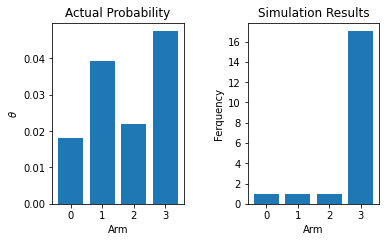

In [74]:
arm_count = [row[1] for row in sorted(Counter(selected_arms_logisticTS[0,:]).items())]
plt.subplot(1,2,1)
plt.bar(range(4), [Env.p(arm) for arm in arms], tick_label=range(4))
plt.xlabel('Arm')
plt.ylabel(r'$\theta$')
plt.title('Actual Probability')
plt.subplot(1,2,2)
plt.bar(range(4), arm_count, tick_label=range(4))
plt.xlabel('Arm')
plt.ylabel('Ferquency')
plt.title('Simulation Results')
plt.tight_layout(pad=3)
plt.savefig(path_fig + "result_logistic_TS.png")
plt.show()

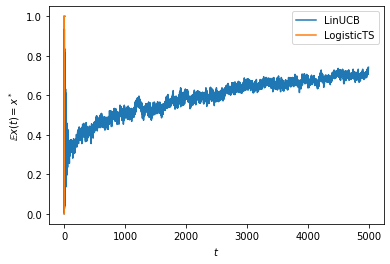

In [75]:
plt.plot(np.mean(selected_arms_linucb==Env.opt(), axis=0), label='LinUCB')
plt.plot(np.mean(selected_arms_logisticTS==Env.opt(), axis=0), label='LogisticTS')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}{x(t) = x^*}$')
plt.legend()
plt.savefig(path_fig  + "compare_logisticTS_vs_linucb.png", bbox_inches="tight")
plt.show()

## 悲しくも没になったもの

### Logistic Thompson Sampling

In [94]:
# LogisticTSアルゴリズムのクラス
class LogisticTSAgent:
    """
    Args :
        num_theta_max_iter : theta の探索を行う反復回数の上限
        epsilon : theta の探索を行う際の収束許容誤差
        interval_update_theta : thetaの更新を行う間隔. この回数だけ反復したら theta, hessian を更新する
    """
    def __init__(self, sigma_0=0.1, num_theta_max_iter=1000, epsilon=0.01, interval_update_theta=10):
        self.sigma_0 = sigma_0
        self.num_theta_max_iter = num_theta_max_iter
        self.epsilon = epsilon
        self.interval_update_theta = interval_update_theta
    
    def initialize(self, n_arms, n_features, sigma):
        """環境の初期化関数
        
        Args:
            n_arms     : 引ける腕の数
            n_features : 文脈の次元数
            sigma      : 誤差項の分散
            
        Attributes:
            iter_num : 現在の反復回数
            lst_context_history(list[np.array]) : 引いた腕のcontextリスト
            lst_reward_history(list[int]) : 引いた腕の報酬リスト. 0 or 1
            H_inv(np.array) : 乱数生成に必要なヘシアンの逆行列
        """
        self.n_arms = n_arms
        self.n_features = n_features
        self.sigma  = sigma
        self.theta  = np.zeros(n_features)
        
        self.iter_num = 0
        self.lst_context_history = []
        self.lst_reward_history = []
        self.H_inv = self.calc_hessian_inv(self.theta)
        return
        
    def calc_gradient(self, theta):
        """負の対数事後確率の勾配 G の計算"""
        # 初期値
        ret = []
        ret.append(theta / self.sigma_0)
        
        # 以下、引いた腕によって変わる
        for context in self.lst_context_history:
            exp_theta_T_context = np.exp(theta.dot(context))
            ret.append((exp_theta_T_context*context)/(1 + exp_theta_T_context))
            
        for idx, reward in enumerate(self.lst_reward_history):
            if reward == 1:
                ret.append(self.lst_context_history[idx] * -1)
                
        return np.array(ret).sum(axis=0)
    
    def calc_hessian_inv(self, theta):
        """負の対数事後確率のヘシアン H の逆行列の計算"""
        ret = []
        ret.append(np.identity(self.n_features)/self.sigma_0)

        for context in self.lst_context_history:
            exp_theta_T_context = np.exp(theta.dot(context))
            ret.append((exp_theta_T_context*(np.matrix(context).T)*context)/(1+exp_theta_T_context)**2)

        return np.linalg.inv(np.array(ret).sum(axis=0))
        
    def set_theta(self, theta):
        """theta の係数格納"""
        self.theta = theta
        return
        
    def get_theta_by_normalDistribution(self):
        """多変量正規分布からパラメータを取得"""
        theta_tild = np.random.multivariate_normal(
            self.theta,
            self.H_inv
        )
        return theta_tild
    
    def get_arm(self, context):
        """腕を選択"""
        np_context = np.array(context)
        theta_tild = self.get_theta_by_normalDistribution()
        
        score = np_context.dot(theta_tild)
        return np.argmax(score)
        
    def add_reward(self, reward):
        """得られた報酬のリストに追加"""
        self.lst_reward_history.append(reward)
        return
        
    def add_context(self, context):
        """選択した腕のcontextをリストに追加"""
        self.lst_context_history.append(np.array(context))
        return
    
    def update_theta(self):
        """観測した報酬からtheta更新"""
        # 設定した更新間隔に達していなければ、更新しない
        if self.iter_num % self.interval_update_theta != 0:
            return
        
        # thetaが収束するか規定回数を反復するまで計算する
        theta_hat = self.theta
        for i in range(self.num_theta_max_iter):
            theta_before = theta_hat
            G = self.calc_gradient(theta_hat)
            H_inv = self.calc_hessian_inv(theta_hat)
            
            theta_hat = theta_hat - H_inv.dot(G)
            
            # 収束したら終了
            ## 収束しなかったらthetaを更新して再計算
            if np.linalg.norm(theta_hat - theta_before) < self.epsilon:
                break
        # 規定回数までに収束しなかったら表示
        if i == self.num_theta_max_iter-1:
            print("max iter over")
            
        # 収束したら更新
        self.set_theta(theta_hat)
        return 
    
    def sample(self, context, reward):
        """選択した腕の文脈とその報酬を得て、更新を行う"""
        self.iter_num += 1
        self.add_reward(reward)
        self.add_context(context)
        self.update_theta()

In [95]:
agent = LogisticTSAgent()
features = np.array([[arm[0], arm[1], 1] for arm in arms])
agent.initialize(n_arms=len(arms), n_features=len(features[0]), sigma=1)
s_arm = []
e_reward = []

In [96]:
for step in tqdm(range(n_step)):
    arm_index = agent.get_arm(features)
    reward = Env.react(arms[arm_index])
    agent.sample(features[arm_index], reward)
    s_arm.append(arm_index)
    e_reward.append(reward)

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:33<00:00, 23.43it/s]


In [62]:
n_iter = 500
n_step = 5000
selected_arms_logisticTS = np.zeros((n_iter, n_step), dtype=int)
earned_rewards_logisticTS = np.zeros((n_iter, n_step), dtype=int)
for it in tqdm(range(n_iter)):
    agent = LogisticTSAgent()
    agent.initialize(n_arms=len(arms), n_features=len(arms[0]), sigma=1)
    for step in range(n_step):
        arm_index = agent.get_arm(arms)
        reward = Env.react(arms[arm_index])
        agent.sample(arms[arm_index], reward)
        selected_arms_logisticTS[it, step] = arm_index
        earned_rewards_logisticTS[it, step] = reward

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [6:11:41<00:00, 44.60s/it]


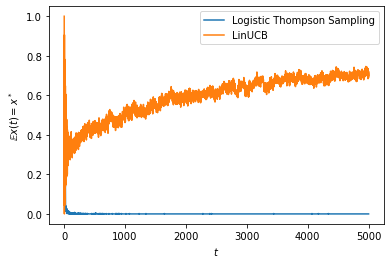

In [63]:
plt.plot(np.mean(selected_arms_logisticTS==Env.opt(), axis=0), label=r'Logistic Thompson Sampling')
plt.plot(np.mean(selected_arms_linucb==Env.opt(), axis=0), label=r'LinUCB')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}{x(t) = x^*}$')
plt.legend()
plt.savefig("result_logistic_TS.png", bbox_inches="tight")
plt.show()